In [4]:
%pip install "transformers>=4.11.3" sentencepiece sentencepiece scikit-plot wordcloud openpyxl autopep8 nlpaug "torch==1.8" nltk seaborn

Note: you may need to restart the kernel to use updated packages.


In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import numpy
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,classification_report
from scikitplot.metrics import plot_confusion_matrix
from wordcloud import WordCloud
from collections import defaultdict
import nlpaug.augmenter.word as naw
import json

In [6]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [7]:
initial_df = pd.read_excel("Dataset.xlsx", index_col=None, usecols="A:B")
initial_df

Column1.data.text  Emotion
0    @RouleLaCookie @luXemusicBX @toda_pisteur Non ...   Dégoût
1    @YarrV @m_nguea Oui cest quand même un gros ra...   Dégoût
2    @salzermorrayOFF @OMjee972 @Diamarc10 @LordDos...   Colère
3    Booba il parle que du père de Vald mais on s'e...   Colère
4    @RGang972 Oui bon sachons raison garder quand ...  INCONNU
..                                                 ...      ...
964  Finito booba c’est très grave https://t.co/APC...   Dégoût
965  @lilcamscar @nolabuche @vald_ld ça c’est vous ...     Joie
966      @RapAtlas_ Si Booba ne change pas de trottoir  INCONNU
967  Au moins il es premier lui… https://t.co/KZku8...  INCONNU
968  @nolabuche @TheoneMsk @vald_ld Mais frère ON P...   Colère

[969 rows x 2 columns]

<AxesSubplot:xlabel='Emotion', ylabel='count'>

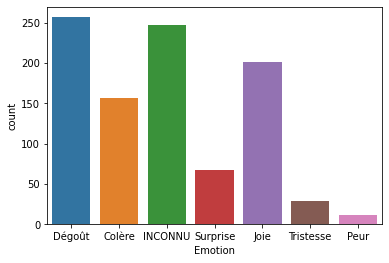

In [8]:
sns.countplot(x=initial_df.Emotion)

In [9]:
cleaned_df = initial_df.replace(to_replace="(@\w+)|(http[a-zA-Z\:\/\.]+)", value ="", regex=True)
def custom_encoder(df):
    df = df.replace(to_replace ="Surprise", value =6)
    df = df.replace(to_replace ="Joie", value =5)
    df = df.replace(to_replace ="Dégoût", value =4)
    df = df.replace(to_replace ="Peur", value =3)
    df = df.replace(to_replace ="Colère", value =2)
    df = df.replace(to_replace ="Tristesse", value =1)
    df = df.replace(to_replace ="INCONNU", value =0)
    return df
cleaned_df = custom_encoder(cleaned_df)
# Since we have our own way of tagging, we need to randomize the set
cleaned_df = cleaned_df.sample(frac=1, random_state=1).reset_index(drop=True)

In [10]:
lm = WordNetLemmatizer()
def text_transformation(df_col):
    corpus = []
    for item in df_col:
        new_item = re.sub('[^a-zA-Z]',' ',str(item))
        new_item = new_item.lower()
        new_item = new_item.split()
        new_item = [lm.lemmatize(word) for word in new_item if word not in set(stopwords.words('french'))]
        corpus.append(' '.join(str(x) for x in new_item))
    return corpus

In [38]:
cv = CountVectorizer(ngram_range=(1,2), strip_accents="ascii")
X_train, X_test, y_train, y_test = train_test_split(cleaned_df['Column1.data.text'], cleaned_df['Emotion'],  test_size=0.2, random_state=1)

In [14]:
# aug1 = naw.SynonymAug(aug_src='wordnet', lang="fra")
aug1 = naw.SynonymAug(aug_src='ppdb', lang="fra",
                      model_path="ppdb-1.0-s-lexical")
aug2 = naw.BackTranslationAug(
    from_model_name='Helsinki-NLP/opus-mt-fr-en',
    to_model_name='Helsinki-NLP/opus-mt-en-fr',
    device="cpu"
)


def augment_text(array):
    new_text = list()
    for i, elm in enumerate(array):
        print(f"Processing entry {i+1}/{len(array)} : {str(elm)}")
        augmented_text1 = aug1.augment(elm, num_thread=16)
        new_text.append(augmented_text1)
        augmented_text2 = aug2.augment(augmented_text1, num_thread=16)
        new_text.append(augmented_text2)
        print("Found: " + augmented_text1 + " and " + augmented_text2)
    return new_text


augmented_text = augment_text(X_train)
with open('augmented_text.json', 'w') as outfile:
    json.dump(augmented_text, outfile)

Processing entry 1/775 :     Quand t'as vendu 50k de physique en 1iere semaine c'est logique de chuter comme ça néanmoins ça reste une très grosse 2ieme semaine (on rapelle que certains vendrait leur mère pour avoir ça en 1iere semaine)
Found: Quand t ' as vendu 50k de physique en 1iere semaine c. ' est logiques de chuter aimes ça néanmoins ça reste a três gros 2ieme semaine (on rapelle que certaines vendrait leur mère pour a que par 1iere semaine ) and Quand vous avez vendu 50k de physique dans la première semaine c. il est logique de tomber comme ça bien qu'il reste une très grande 2e semaine (rappelez-vous que certains vendraient leur mère pour seulement une première semaine )
Processing entry 2/775 : Vald il est trop con. Si y a bien une personne qu’il faut ignorer c’est booba
Found: Vald il est trop con. Si sont a correctement une personnes que ’ ca faut ignoré ch ’ est booba and Vald c'est trop stupide. Donc, ils ont une bonne personne qui doit être ignorée ch est booba
Processin

In [39]:
with open('augmented_text.json') as json_file:
    augmented_text = json.load(json_file)
X_train = cv.fit_transform(text_transformation(
    X_train) + text_transformation(augmented_text))
y_train2 = (list(y_train) + list(y_train.repeat(2)))


In [40]:
y_train2

[5,
 4,
 0,
 0,
 5,
 0,
 4,
 2,
 4,
 4,
 0,
 0,
 0,
 5,
 5,
 0,
 4,
 0,
 4,
 6,
 5,
 5,
 4,
 4,
 4,
 0,
 5,
 0,
 2,
 4,
 0,
 6,
 2,
 0,
 1,
 5,
 5,
 3,
 5,
 4,
 4,
 4,
 2,
 4,
 4,
 6,
 0,
 4,
 4,
 5,
 3,
 4,
 4,
 4,
 0,
 4,
 2,
 5,
 5,
 4,
 5,
 4,
 4,
 5,
 0,
 0,
 2,
 2,
 0,
 6,
 0,
 2,
 0,
 5,
 5,
 4,
 4,
 0,
 4,
 2,
 5,
 0,
 2,
 6,
 5,
 2,
 0,
 4,
 5,
 2,
 4,
 5,
 4,
 2,
 6,
 5,
 2,
 5,
 0,
 4,
 4,
 0,
 4,
 5,
 4,
 0,
 0,
 5,
 5,
 5,
 0,
 4,
 0,
 2,
 4,
 0,
 5,
 2,
 0,
 4,
 4,
 5,
 0,
 2,
 5,
 5,
 4,
 0,
 0,
 4,
 4,
 4,
 5,
 4,
 1,
 2,
 0,
 4,
 0,
 4,
 4,
 0,
 2,
 4,
 6,
 4,
 4,
 1,
 5,
 1,
 6,
 0,
 5,
 0,
 6,
 0,
 4,
 0,
 2,
 0,
 0,
 5,
 2,
 6,
 0,
 0,
 4,
 2,
 5,
 5,
 0,
 4,
 0,
 0,
 0,
 4,
 5,
 4,
 4,
 0,
 4,
 5,
 2,
 0,
 4,
 4,
 5,
 4,
 3,
 4,
 4,
 4,
 2,
 0,
 2,
 2,
 4,
 4,
 4,
 4,
 0,
 5,
 5,
 5,
 2,
 0,
 0,
 4,
 2,
 5,
 4,
 4,
 0,
 1,
 5,
 1,
 2,
 0,
 5,
 2,
 4,
 2,
 0,
 0,
 3,
 4,
 4,
 5,
 6,
 2,
 0,
 0,
 6,
 4,
 4,
 4,
 5,
 5,
 5,
 0,
 2,
 4,
 5,
 5,
 1,
 0,
 0,
 4,
 0,
 0,


In [16]:
word_cloud = ""
for row in text_transformation(cleaned_df['Column1.data.text']):
    for word in row:
        word_cloud+=" ".join(word)
wordcloud = WordCloud(width = 2000, height = 1000,background_color ='white',min_font_size = 15).generate(word_cloud)
file = open("./wordcloud.svg", "w")
file.write(wordcloud.to_svg(embed_font=True, optimize_embedded_font=True))
file.close()

In [41]:
parameters = {'max_features': ('auto','sqrt'),
             'n_estimators': [500, 1000, 1500],
             'max_depth': [5, 10, None],
             'min_samples_split': [5, 10, 15],
             'min_samples_leaf': [1, 2, 5, 10],
             'bootstrap': [True, False]}
grid_search = GridSearchCV(RandomForestClassifier(),parameters,cv=5,return_train_score=True,n_jobs=-1)

In [43]:
grid_search.fit(X_train,y_train2)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [5, 10, None],
                         'max_features': ('auto', 'sqrt'),
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [5, 10, 15],
                         'n_estimators': [500, 1000, 1500]},
             return_train_score=True)

In [44]:
grid_search.best_score_

0.7853763440860215

In [45]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 1000}

In [46]:
#Check on 10-entries sample
for i in range(10):
    print('Parameters: ',grid_search.cv_results_['params'][i])
    print('Mean Test Score: ',grid_search.cv_results_['mean_test_score'][i])
    print('Rank: ',grid_search.cv_results_['rank_test_score'][i])

Parameters:  {'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
Mean Test Score:  0.27010752688172046
Rank:  365
Parameters:  {'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1000}
Mean Test Score:  0.2705376344086022
Rank:  351
Parameters:  {'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1500}
Mean Test Score:  0.2705376344086021
Rank:  362
Parameters:  {'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500}
Mean Test Score:  0.27096774193548384
Rank:  345
Parameters:  {'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 1000}
Mean Test Score:  0.2705376344086021
Rank:  362
Parameters:  {'bootstrap': True, 'max_depth': 5,

In [49]:
{'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 1000}
rfc = RandomForestClassifier(max_features='sqrt',
                                      max_depth=None,
                                      n_estimators=1000,
                                      min_samples_split=5,
                                      min_samples_leaf=2,
                                      bootstrap=False)

# rfc = RandomForestClassifier(max_features=grid_search.best_params_['max_features'],
#                                       max_depth=grid_search.best_params_['max_depth'],
#                                       n_estimators=grid_search.best_params_['n_estimators'],
#                                       min_samples_split=grid_search.best_params_['min_samples_split'],
#                                       min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
#                                       bootstrap=grid_search.best_params_['bootstrap'])
rfc.fit(X_train,y_train2)

RandomForestClassifier(bootstrap=False, max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=1000)

In [50]:
testdata = cv.transform(text_transformation(X_test))
#predict the target
predictions = rfc.predict(testdata)

In [51]:
labels = [0,1,2,3,4,5,6]
emotions = ["INCONNU", "Tristesse", "Colère", "Peur", "Dégoût", "Joie", "Surprise"]
def custom_decoder(val):
        return emotions[val]


recall_score(y_test.values, predictions, average=None, 
             labels=labels, zero_division=0)


array([0.71929825, 0.        , 0.2       , 0.        , 0.28571429,
       0.28571429, 0.07142857])

In [54]:
pd.set_option("display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None)
test_df = pd.DataFrame(data={"Tweet": X_test, "Emotion": map(custom_decoder, predictions), "Should be": map(custom_decoder, y_test)})
test_df

Tweet  \
718                                                                                                                                                                                                                                                                        Oui et même ne le compare plus   
637                                                                                                                                                                                                                                                         Booba a des combats en thaï, c pas un random    
759                                                                                                      Lol, c'est un stratège ce fumier, il attaque les autres pile au moment où ils ont du buzz côté vente... Sinik, Rohff, Diam's, LaFouine, Youssoupha, Kaaris, Damso, SCH, Ninho et maintenant Vald   
366                                                                                                                                                                                                              Le plus facile c'est d'aller voir la story de vald sur insta tu aura direct les extraits   
543                                                                                                                                                                                                 Je me suis dis: whoa il va hagar quelqu’un avec une bombe atomique et une des armées les plus fortes?   
41                                                                                                                                                                                                                                                      Est-ce qu'ils me connaissent ces deux lascars ? 🙃   
120                                                                                                                                                                                                                                                            Le deuxième screen est faux renseigné vous   
725                                                                                                                                                                                               Vald ne vaut pas mieux que Booba c’est ouf, des gosses, Ninho il a eu la maturité de ne pas répondre 0V   
795                                                                                                                                                                                                                                                               C’est complètement l’inverse 9s1XiCxhVO   
672                                                                                                                                                                                                                                                                 ce serait l’apogée du rap FR oui oui    
473                                                                                                                                                                                                                                                                                          c'est réel ?   
189                                                                                                                                                                                                                                      Ce petit bouffon de booba ! Quand c’est Rohff, il parle tamoul!    
870                                                                                                                                                                                                                                                             c’est toi qu’est venue sous mon tweet mdr   
812                                                                           